In [1]:
import time
import psutil
import numpy as np
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from tensorflow import keras
from sklearn.metrics import matthews_corrcoef, accuracy_score, root_mean_squared_error, mean_squared_error, mean_absolute_error, precision_score, confusion_matrix, multilabel_confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import gc
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

2025-05-13 11:03:55.453775: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747123435.481504   73303 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747123435.487231   73303 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747123435.502243   73303 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747123435.502262   73303 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747123435.502264   73303 computation_placer.cc:177] computation placer alr

# Functions

In [2]:
def visualize_CM(matrix):
    """
    Visualize Correlation Matrix
    """
    sns.heatmap(matrix,annot=True)

def measure_latency_cpu_usage(model, test_inputs):
    process = psutil.Process()
    cpu_start = process.cpu_percent()
    start = time.time()
    predictions = model.predict(test_inputs)
    end = time.time()
    cpu_end = process.cpu_percent()
    latency = end - start
    cpu_usage = cpu_end - cpu_start
    return latency, cpu_usage

# Load data

In [3]:
data = pd.read_csv('data/CIC_IoT2023/custom/binary_classification_data.csv')

In [4]:
data = data.drop(['Unnamed: 0', 'label', 'Attack Type'], axis=1)

In [5]:
data.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Class
0,0.042561,3077.94,16.89,64.00,36400.751310,36400.751310,0.0,0.0,0.0,0.0,...,1.921533,50.62,8.301635e+07,9.5,10.053453,2.722150,31.271048,0.12,141.55,Attack
1,0.029488,13121.00,16.83,63.36,11326.661293,11326.661293,0.0,0.0,0.0,0.0,...,0.342997,50.10,8.310644e+07,9.5,10.010033,0.485827,0.922878,0.13,141.55,Attack
2,0.000093,55.10,6.11,64.58,172.441464,172.441464,0.0,0.0,0.0,0.0,...,2.144515,54.36,8.307625e+07,9.5,10.479273,3.035528,25.971035,0.19,141.55,Attack
3,0.000000,54.00,6.00,64.00,2.737399,2.737399,0.0,0.0,0.0,0.0,...,0.000000,54.00,8.306398e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,Attack
4,0.000000,54.00,6.00,64.00,17.651940,17.651940,0.0,0.0,0.0,0.0,...,0.000000,54.00,8.303405e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,Attack


In [6]:
data.tail()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Class
599995,32.820355,35497.2,9.3,120.5,9.369932,9.369932,0.0,0.0,0.0,0.0,...,86.704499,137.5,1.665198e+08,13.5,14.582491,121.236679,7367.590182,1.0,244.6,Benign
599996,71.611939,110533.2,7.0,65.9,17.676581,17.676581,0.0,0.0,0.0,0.0,...,203.070312,226.2,1.456461e-02,5.5,17.712195,287.184789,84417.097432,0.9,38.5,Benign
599997,19.192783,1900653.7,6.0,214.8,104.295310,104.295310,0.0,0.0,0.0,0.0,...,405.348792,66.0,1.665228e+08,13.5,19.536899,574.466102,166158.498723,1.0,244.6,Benign
599998,58.231502,1773541.9,12.6,133.5,25.655042,25.655042,0.0,0.0,0.0,0.0,...,463.349243,216.4,9.113193e-03,5.5,25.324125,655.274783,245165.553312,0.9,38.5,Benign
599999,15.780854,889539.8,6.0,94.2,83.747435,83.747435,0.0,0.0,0.0,0.0,...,337.504993,799.0,5.663800e-03,5.5,23.064161,477.304139,220375.090153,0.7,38.5,Benign


In [7]:
attacks = data.loc[data['Class'] == 'Attack']
benign = data.loc[data['Class'] == 'Benign']

In [8]:
attacks

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Class
0,0.042561,3077.94,16.89,64.00,36400.751310,36400.751310,0.0,0.0,0.0,0.0,...,1.921533,50.62,8.301635e+07,9.5,10.053453,2.722150,31.271048,0.12,141.55,Attack
1,0.029488,13121.00,16.83,63.36,11326.661293,11326.661293,0.0,0.0,0.0,0.0,...,0.342997,50.10,8.310644e+07,9.5,10.010033,0.485827,0.922878,0.13,141.55,Attack
2,0.000093,55.10,6.11,64.58,172.441464,172.441464,0.0,0.0,0.0,0.0,...,2.144515,54.36,8.307625e+07,9.5,10.479273,3.035528,25.971035,0.19,141.55,Attack
3,0.000000,54.00,6.00,64.00,2.737399,2.737399,0.0,0.0,0.0,0.0,...,0.000000,54.00,8.306398e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,Attack
4,0.000000,54.00,6.00,64.00,17.651940,17.651940,0.0,0.0,0.0,0.0,...,0.000000,54.00,8.303405e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,Attack
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,0.000553,54.58,6.00,64.00,17.516119,17.516119,0.0,0.0,1.0,0.0,...,0.000000,54.00,8.309414e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,Attack
299996,0.000000,54.00,6.00,64.00,23.596050,23.596050,0.0,0.0,0.0,0.0,...,0.000000,54.00,8.294670e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,Attack
299997,0.000000,54.00,6.00,64.00,20.263154,20.263154,0.0,0.0,0.0,0.0,...,0.000000,54.00,8.306724e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,Attack
299998,0.000000,54.00,6.00,64.00,3.707481,3.707481,0.0,0.0,1.0,0.0,...,0.000000,54.00,8.298166e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,Attack


In [9]:
benign

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Class
300000,25.634449,2041382.5,6.0,148.0,55.096694,55.096694,0.0,0.0,0.0,0.0,...,406.594882,780.0,4.037595e-03,5.5,47.967062,575.011996,2.770045e+05,0.6,38.5,Benign
300001,93.393063,194516.9,6.0,80.1,10.044719,10.044719,0.0,0.0,0.0,0.0,...,529.802207,922.2,4.718494e-03,5.5,36.402911,749.253467,3.514827e+05,0.8,38.5,Benign
300002,2.007331,511219.2,6.0,80.7,209.480134,209.480134,0.0,0.0,0.0,0.0,...,2022.080470,2238.0,1.665180e+08,13.5,60.835527,2866.118578,4.132241e+06,1.0,244.6,Benign
300003,0.165718,2127.6,6.5,57.6,10571.153493,10571.153493,0.0,0.0,0.0,0.0,...,135.519041,216.0,1.665179e+08,13.5,16.402380,161.196077,1.304389e+04,1.0,244.6,Benign
300004,94.440591,6271338.7,6.0,80.8,59.849069,59.849069,0.0,0.0,0.0,0.0,...,313.867567,1224.4,2.953982e-03,5.5,52.431584,443.875770,1.655302e+05,0.6,38.5,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,32.820355,35497.2,9.3,120.5,9.369932,9.369932,0.0,0.0,0.0,0.0,...,86.704499,137.5,1.665198e+08,13.5,14.582491,121.236679,7.367590e+03,1.0,244.6,Benign
599996,71.611939,110533.2,7.0,65.9,17.676581,17.676581,0.0,0.0,0.0,0.0,...,203.070312,226.2,1.456461e-02,5.5,17.712195,287.184789,8.441710e+04,0.9,38.5,Benign
599997,19.192783,1900653.7,6.0,214.8,104.295310,104.295310,0.0,0.0,0.0,0.0,...,405.348792,66.0,1.665228e+08,13.5,19.536899,574.466102,1.661585e+05,1.0,244.6,Benign
599998,58.231502,1773541.9,12.6,133.5,25.655042,25.655042,0.0,0.0,0.0,0.0,...,463.349243,216.4,9.113193e-03,5.5,25.324125,655.274783,2.451656e+05,0.9,38.5,Benign


In [10]:
attacks_upd = attacks.sample(n = 30000)
benign_upd = benign.sample(n = 30000)
data_upd = pd.concat([attacks_upd, benign_upd])

In [11]:
data_upd

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Class
245285,2.426706,127.98,6.00,64.00,1.165852,1.165852,0.0,0.0,1.0,0.0,...,0.000000,54.00,8.336538e+07,9.5,10.392305,0.000000,0.000000e+00,0.00,141.55,Attack
298671,0.000000,52.92,5.88,62.72,18.730467,18.730467,0.0,0.0,0.0,0.0,...,0.189317,54.12,8.307646e+07,9.5,10.397101,0.268643,2.796946e-01,0.13,141.55,Attack
260401,0.000000,0.00,1.00,64.00,2.657562,2.657562,0.0,0.0,0.0,0.0,...,0.000000,42.00,8.312906e+07,9.5,9.165151,0.000000,0.000000e+00,0.00,141.55,Attack
164554,0.000000,54.00,6.00,64.00,0.974109,0.974109,0.0,1.0,0.0,1.0,...,0.000000,54.00,8.334087e+07,9.5,10.392305,0.000000,0.000000e+00,0.00,141.55,Attack
30160,4.615732,108.00,6.00,64.00,0.433301,0.433301,0.0,1.0,0.0,1.0,...,0.000000,54.00,8.334933e+07,9.5,10.392305,0.000000,0.000000e+00,0.00,141.55,Attack
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412890,30.757546,2673550.00,6.00,231.00,79.183820,79.183820,0.0,0.0,0.0,0.0,...,313.891084,66.00,1.665240e+08,13.5,19.171945,444.822569,9.955314e+04,1.00,244.60,Benign
424294,98.334633,228211.80,6.00,97.40,18.692740,18.692740,0.0,0.0,0.0,0.0,...,42.118346,124.20,4.312992e-03,5.5,13.973687,59.564336,2.968391e+03,0.60,38.50,Benign
554808,5.529098,854470.00,6.00,232.00,141.343050,141.343050,0.0,0.0,0.0,0.0,...,0.000000,66.00,3.638983e-04,5.5,11.489125,0.000000,0.000000e+00,0.00,38.50,Benign
511836,68.436771,4586068.10,6.00,64.00,58.802499,58.802499,0.0,0.0,0.0,0.0,...,835.134093,1717.10,6.979704e-03,5.5,59.494694,1181.057961,1.397439e+06,0.50,38.50,Benign


In [12]:
X = data_upd.drop(['Class'], axis = 1)
y = data_upd['Class']

In [13]:
X.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,AVG,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight
245285,2.426706,127.98,6.00,64.00,1.165852,1.165852,0.0,0.0,1.0,0.0,...,54.000000,0.000000,54.00,8.336538e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55
298671,0.000000,52.92,5.88,62.72,18.730467,18.730467,0.0,0.0,0.0,0.0,...,54.049618,0.189317,54.12,8.307646e+07,9.5,10.397101,0.268643,0.279695,0.13,141.55
260401,0.000000,0.00,1.00,64.00,2.657562,2.657562,0.0,0.0,0.0,0.0,...,42.000000,0.000000,42.00,8.312906e+07,9.5,9.165151,0.000000,0.000000,0.00,141.55
164554,0.000000,54.00,6.00,64.00,0.974109,0.974109,0.0,1.0,0.0,1.0,...,54.000000,0.000000,54.00,8.334087e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55
30160,4.615732,108.00,6.00,64.00,0.433301,0.433301,0.0,1.0,0.0,1.0,...,54.000000,0.000000,54.00,8.334933e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55


In [14]:
y

245285    Attack
298671    Attack
260401    Attack
164554    Attack
30160     Attack
           ...  
412890    Benign
424294    Benign
554808    Benign
511836    Benign
560650    Benign
Name: Class, Length: 60000, dtype: object

In [15]:
y.value_counts()

Class
Attack    30000
Benign    30000
Name: count, dtype: int64

In [16]:
le = LabelEncoder()

y = le.fit_transform(y)

In [17]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Binary Classification

In [18]:
results_dict = {}

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((51000, 46), (51000,), (9000, 46), (9000,))

# K Nearest Neighbour

In [20]:
%%time

start_time = time.perf_counter()

knn_clf = KNeighborsClassifier(n_jobs=8)
knn_clf.fit(X_train, y_train)

y_pred = knn_clf.predict(X_test)

end_time = time.perf_counter()

kNN_time = end_time - start_time

CPU times: user 3.28 s, sys: 7.84 ms, total: 3.28 s
Wall time: 965 ms


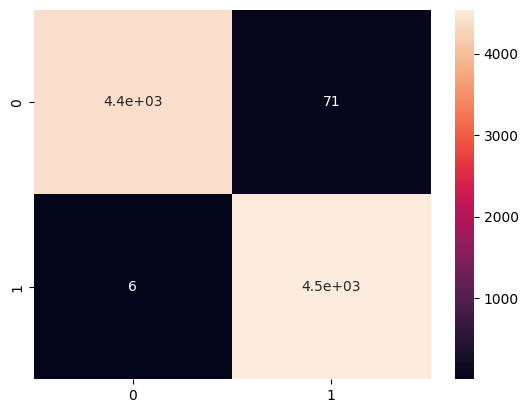

In [21]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [22]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)
latency, cpu_usage = measure_latency_cpu_usage(knn_clf, X_test)

In [23]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, latency, kNN_time]
results_dict["kNN"] = results

In [24]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Tikslumas", "Precizija", "F1", "Atpažinimas", "MCC", "MAE", "MSE", "RMSE", "Uždelstumas", "Laikas"])

,Tikslumas,Precizija,F1,Atpažinimas,MCC,MAE,MSE,RMSE,Uždelstumas,Laikas
kNN,0.991444,0.991546,0.991443,0.991444,0.982987,0.008556,0.008556,0.092496,0.860921,0.964774


# Naive Bayes

In [25]:
%%time

start_time = time.perf_counter()

nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)

y_pred = nb_clf.predict(X_test)

end_time = time.perf_counter()

NB_time = end_time - start_time

CPU times: user 37.5 ms, sys: 1.98 ms, total: 39.4 ms
Wall time: 38.9 ms


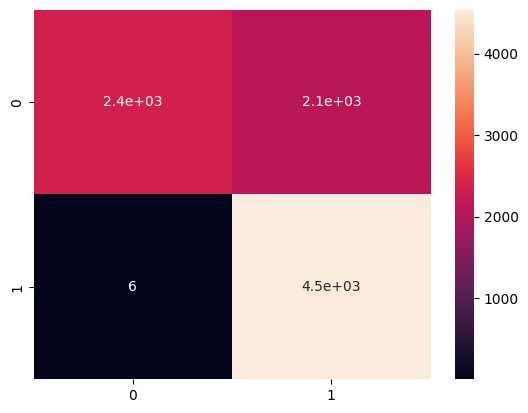

In [26]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [27]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)
latency, cpu_usage = measure_latency_cpu_usage(nb_clf, X_test)

In [28]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, latency, NB_time]
results_dict["NB"] = results

In [29]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Tikslumas", "Precizija", "F1", "Atpažinimas", "MCC", "MAE", "MSE", "RMSE", "Uždelstumas", "Laikas"])

,Tikslumas,Precizija,F1,Atpažinimas,MCC,MAE,MSE,RMSE,Uždelstumas,Laikas
kNN,0.991444,0.991546,0.991443,0.991444,0.982987,0.008556,0.008556,0.092496,0.860921,0.964774
NB,0.766667,0.839331,0.752766,0.766667,0.600385,0.233333,0.233333,0.483046,0.004500,0.038924


# Logistic Regression

In [30]:
%%time

start_time = time.perf_counter()

lr_clf = LogisticRegression(max_iter = 10000, C = 0.1, random_state = 0, solver = 'saga', n_jobs=8)
lr_clf.fit(X_train, y_train)

y_pred = lr_clf.predict(X_test)

end_time = time.perf_counter()

LR_time = end_time - start_time

CPU times: user 2min 11s, sys: 268 ms, total: 2min 11s
Wall time: 2min 13s


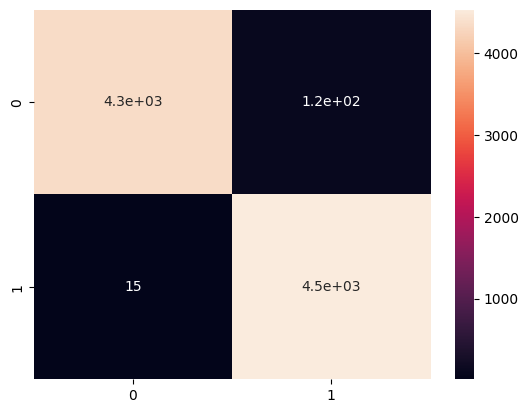

In [31]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [32]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)
latency, cpu_usage = measure_latency_cpu_usage(lr_clf, X_test)

In [33]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, latency, LR_time]
results_dict["LR"] = results

In [34]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Tikslumas", "Precizija", "F1", "Atpažinimas", "MCC", "MAE", "MSE", "RMSE", "Uždelstumas", "Laikas"])

,Tikslumas,Precizija,F1,Atpažinimas,MCC,MAE,MSE,RMSE,Uždelstumas,Laikas
kNN,0.991444,0.991546,0.991443,0.991444,0.982987,0.008556,0.008556,0.092496,0.860921,0.964774
NB,0.766667,0.839331,0.752766,0.766667,0.600385,0.233333,0.233333,0.483046,0.004500,0.038924
LR,0.985111,0.985367,0.985107,0.985111,0.970472,0.014889,0.014889,0.122020,0.000769,133.183392


# Random Forest

In [35]:
%%time

start_time = time.perf_counter()

rf_clf = RandomForestClassifier(n_jobs=8)
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)

end_time = time.perf_counter()

RF_time = end_time - start_time

CPU times: user 16.9 s, sys: 102 ms, total: 17 s
Wall time: 2.93 s


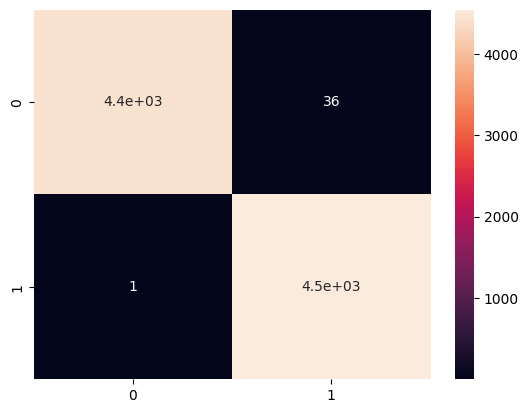

In [36]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [37]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)
latency, cpu_usage = measure_latency_cpu_usage(rf_clf, X_test)

In [38]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, latency, RF_time]
results_dict["RF"] = results

In [39]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Tikslumas", "Precizija", "F1", "Atpažinimas", "MCC", "MAE", "MSE", "RMSE", "Uždelstumas", "Laikas"])

,Tikslumas,Precizija,F1,Atpažinimas,MCC,MAE,MSE,RMSE,Uždelstumas,Laikas
kNN,0.991444,0.991546,0.991443,0.991444,0.982987,0.008556,0.008556,0.092496,0.860921,0.964774
NB,0.766667,0.839331,0.752766,0.766667,0.600385,0.233333,0.233333,0.483046,0.004500,0.038924
LR,0.985111,0.985367,0.985107,0.985111,0.970472,0.014889,0.014889,0.122020,0.000769,133.183392
RF,0.995889,0.995919,0.995889,0.995889,0.991806,0.004111,0.004111,0.064118,0.035373,2.930116


# XGBoost

In [40]:
%%time

start_time = time.perf_counter()

xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)

y_pred = xgb_clf.predict(X_test)

end_time = time.perf_counter()

XGBoost_time = end_time - start_time

CPU times: user 23 s, sys: 135 ms, total: 23.1 s
Wall time: 3.78 s


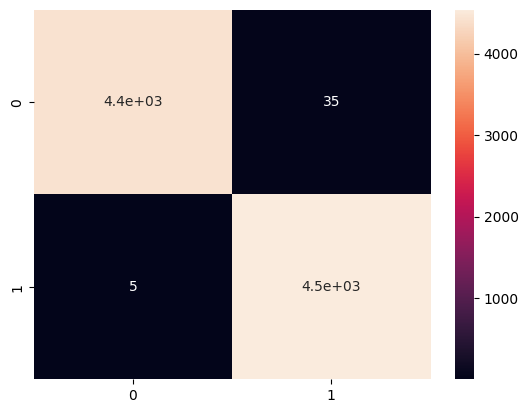

In [41]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [42]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)
latency, cpu_usage = measure_latency_cpu_usage(xgb_clf, X_test)

In [43]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, latency, XGBoost_time]
results_dict["XGBoost"] = results

In [44]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Tikslumas", "Precizija", "F1", "Atpažinimas", "MCC", "MAE", "MSE", "RMSE", "Uždelstumas", "Laikas"])

,Tikslumas,Precizija,F1,Atpažinimas,MCC,MAE,MSE,RMSE,Uždelstumas,Laikas
kNN,0.991444,0.991546,0.991443,0.991444,0.982987,0.008556,0.008556,0.092496,0.860921,0.964774
NB,0.766667,0.839331,0.752766,0.766667,0.600385,0.233333,0.233333,0.483046,0.004500,0.038924
LR,0.985111,0.985367,0.985107,0.985111,0.970472,0.014889,0.014889,0.122020,0.000769,133.183392
RF,0.995889,0.995919,0.995889,0.995889,0.991806,0.004111,0.004111,0.064118,0.035373,2.930116
XGBoost,0.995556,0.995577,0.995555,0.995556,0.991132,0.004444,0.004444,0.066667,0.008036,3.775900


# LightGBM

In [45]:
%%time

start_time = time.perf_counter()

lgbm_clf = lightgbm.LGBMClassifier()
lgbm_clf.fit(X_train, y_train)

y_pred = lgbm_clf.predict(X_test)

end_time = time.perf_counter()

LightGBM_time = end_time - start_time

[LightGBM] [Info] Number of positive: 25456, number of negative: 25544
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 51000, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499137 -> initscore=-0.003451
[LightGBM] [Info] Start training from score -0.003451
CPU times: user 2.06 s, sys: 34.4 ms, total: 2.09 s
Wall time: 570 ms


/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


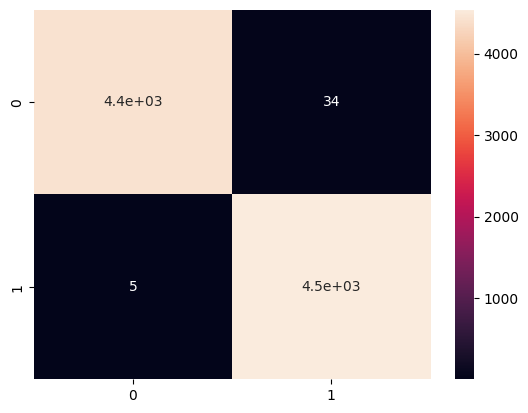

In [46]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [47]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)
latency, cpu_usage = measure_latency_cpu_usage(lgbm_clf, X_test)

/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [48]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, latency, LightGBM_time]
results_dict["LightGBM"] = results

In [49]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Tikslumas", "Precizija", "F1", "Atpažinimas", "MCC", "MAE", "MSE", "RMSE", "Uždelstumas", "Laikas"])

,Tikslumas,Precizija,F1,Atpažinimas,MCC,MAE,MSE,RMSE,Uždelstumas,Laikas
kNN,0.991444,0.991546,0.991443,0.991444,0.982987,0.008556,0.008556,0.092496,0.860921,0.964774
NB,0.766667,0.839331,0.752766,0.766667,0.600385,0.233333,0.233333,0.483046,0.004500,0.038924
LR,0.985111,0.985367,0.985107,0.985111,0.970472,0.014889,0.014889,0.122020,0.000769,133.183392
RF,0.995889,0.995919,0.995889,0.995889,0.991806,0.004111,0.004111,0.064118,0.035373,2.930116
XGBoost,0.995556,0.995577,0.995555,0.995556,0.991132,0.004444,0.004444,0.066667,0.008036,3.775900
LightGBM,0.995667,0.995687,0.995666,0.995667,0.991353,0.004333,0.004333,0.065828,0.018067,0.569587


# Catboost

In [50]:
%%time

start_time = time.perf_counter()

cb_clf = CatBoostClassifier(silent = True)
cb_clf.fit(X_train, y_train)

y_pred = cb_clf.predict(X_test)

end_time = time.perf_counter()

CatBoost_time = end_time - start_time

CPU times: user 41.2 s, sys: 8.22 s, total: 49.5 s
Wall time: 9.45 s


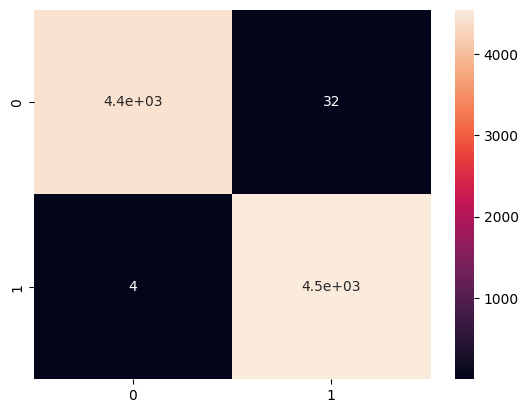

In [51]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [52]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)
latency, cpu_usage = measure_latency_cpu_usage(cb_clf, X_test)

In [53]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, latency, CatBoost_time]
results_dict["CatBoost"] = results

In [54]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Tikslumas", "Precizija", "F1", "Atpažinimas", "MCC", "MAE", "MSE", "RMSE", "Uždelstumas", "Laikas"])

,Tikslumas,Precizija,F1,Atpažinimas,MCC,MAE,MSE,RMSE,Uždelstumas,Laikas
kNN,0.991444,0.991546,0.991443,0.991444,0.982987,0.008556,0.008556,0.092496,0.860921,0.964774
NB,0.766667,0.839331,0.752766,0.766667,0.600385,0.233333,0.233333,0.483046,0.004500,0.038924
LR,0.985111,0.985367,0.985107,0.985111,0.970472,0.014889,0.014889,0.122020,0.000769,133.183392
RF,0.995889,0.995919,0.995889,0.995889,0.991806,0.004111,0.004111,0.064118,0.035373,2.930116
XGBoost,0.995556,0.995577,0.995555,0.995556,0.991132,0.004444,0.004444,0.066667,0.008036,3.775900
LightGBM,0.995667,0.995687,0.995666,0.995667,0.991353,0.004333,0.004333,0.065828,0.018067,0.569587
CatBoost,0.996000,0.996019,0.996000,0.996000,0.992018,0.004000,0.004000,0.063246,0.136298,9.452413


# Support Vector Machine

In [55]:
%%time

start_time = time.perf_counter()

svm_clf = SVC(kernel = 'poly', C = 1, random_state = 0, probability = True)
svm_clf.fit(X_train, y_train)

y_pred = svm_clf.predict(X_test)

end_time = time.perf_counter()

SVM_time = end_time - start_time

CPU times: user 1min 24s, sys: 372 ms, total: 1min 25s
Wall time: 1min 25s


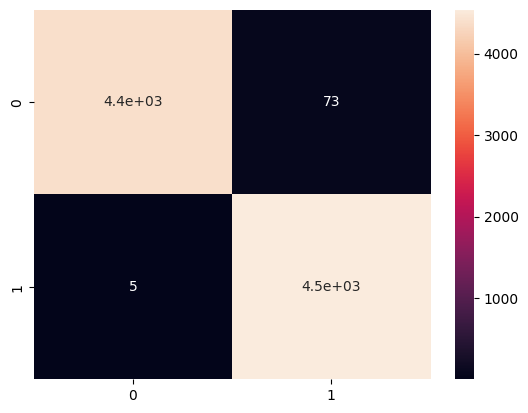

In [56]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [57]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)
latency, cpu_usage = measure_latency_cpu_usage(svm_clf, X_test)

In [58]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, latency, SVM_time]
results_dict["SVM"] = results

In [59]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Tikslumas", "Precizija", "F1", "Atpažinimas", "MCC", "MAE", "MSE", "RMSE", "Uždelstumas", "Laikas"])

,Tikslumas,Precizija,F1,Atpažinimas,MCC,MAE,MSE,RMSE,Uždelstumas,Laikas
kNN,0.991444,0.991546,0.991443,0.991444,0.982987,0.008556,0.008556,0.092496,0.860921,0.964774
NB,0.766667,0.839331,0.752766,0.766667,0.600385,0.233333,0.233333,0.483046,0.004500,0.038924
LR,0.985111,0.985367,0.985107,0.985111,0.970472,0.014889,0.014889,0.122020,0.000769,133.183392
RF,0.995889,0.995919,0.995889,0.995889,0.991806,0.004111,0.004111,0.064118,0.035373,2.930116
XGBoost,0.995556,0.995577,0.995555,0.995556,0.991132,0.004444,0.004444,0.066667,0.008036,3.775900
LightGBM,0.995667,0.995687,0.995666,0.995667,0.991353,0.004333,0.004333,0.065828,0.018067,0.569587
CatBoost,0.996000,0.996019,0.996000,0.996000,0.992018,0.004000,0.004000,0.063246,0.136298,9.452413
SVM,0.991333,0.991444,0.991332,0.991333,0.982775,0.008667,0.008667,0.093095,0.660060,85.645915


# Feed Forward Neural Network

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((41820, 46), (41820,), (9180, 46), (9180,), (9000, 46), (9000,))

In [61]:
def create_model(X_train, y_train):
    model = keras.Sequential()
    model.add(keras.layers.Dense(X_train.shape[1], activation='relu', input_shape=(X_train.shape[1],)))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(len(np.unique(y_train)), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
model = create_model(X_train, y_train)

/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1747123681.933545   73303 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5094 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1


In [62]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 46)             │         2,162 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        12,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,500 (314.45 KB)

 Trainable params: 80,500 (314.45 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
%%time

start_time = time.perf_counter()

model.fit(X_train, y_train,
          batch_size=16,
          epochs=20,
          validation_data=(X_val, y_val))

end_time = time.perf_counter()

gc.collect();

FFNN_Time = end_time - start_time

Epoch 1/20


I0000 00:00:1747123683.285855   78738 service.cc:152] XLA service 0x72688400a840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747123683.285882   78738 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1060, Compute Capability 6.1
2025-05-13 11:08:03.308542: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747123683.452099   78738 cuda_dnn.cc:529] Loaded cuDNN version 90300


  81/2614 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9253 - loss: 0.2526    

I0000 00:00:1747123684.195970   78738 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2614/2614 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9839 - loss: 0.0746 - val_accuracy: 0.9905 - val_loss: 0.0437
Epoch 2/20
2614/2614 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9918 - loss: 0.0345 - val_accuracy: 0.9911 - val_loss: 0.0438
Epoch 3/20
2614/2614 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9920 - loss: 0.0334 - val_accuracy: 0.9917 - val_loss: 0.0379
Epoch 4/20
2614/2614 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9927 - loss: 0.0311 - val_accuracy: 0.9916 - val_loss: 0.0388
Epoch 5/20
2614/2614 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9925 - loss: 0.0306 - val_accuracy: 0.9924 - val_loss: 0.0358
Epoch 6/20
2614/2614 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9931 - loss: 0.0277 - val_accuracy: 0.9920 - val_loss: 0.0346
Epoch 7/20
2614/2614 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9930 - loss: 0.0289 - val_accuracy: 0.9925 - val_loss: 0.0392
Epoch 8/20
2614/2614 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9930 - loss: 0.0263 - val_accurac

In [64]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step    


In [65]:
_, accuracy = model.evaluate(X_test, y_test)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)
latency, cpu_usage = measure_latency_cpu_usage(model, X_test)

282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9919 - loss: 0.0460    
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [66]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, latency, FFNN_Time]
results_dict["FF-NN"] = results

In [67]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Tikslumas", "Precizija", "F1", "Atpažinimas", "MCC", "MAE", "MSE", "RMSE", "Uždelstumas", "Laikas"])

,Tikslumas,Precizija,F1,Atpažinimas,MCC,MAE,MSE,RMSE,Uždelstumas,Laikas
kNN,0.991444,0.991546,0.991443,0.991444,0.982987,0.008556,0.008556,0.092496,0.860921,0.964774
NB,0.766667,0.839331,0.752766,0.766667,0.600385,0.233333,0.233333,0.483046,0.004500,0.038924
LR,0.985111,0.985367,0.985107,0.985111,0.970472,0.014889,0.014889,0.122020,0.000769,133.183392
RF,0.995889,0.995919,0.995889,0.995889,0.991806,0.004111,0.004111,0.064118,0.035373,2.930116
XGBoost,0.995556,0.995577,0.995555,0.995556,0.991132,0.004444,0.004444,0.066667,0.008036,3.775900
LightGBM,0.995667,0.995687,0.995666,0.995667,0.991353,0.004333,0.004333,0.065828,0.018067,0.569587
CatBoost,0.996000,0.996019,0.996000,0.996000,0.992018,0.004000,0.004000,0.063246,0.136298,9.452413
SVM,0.991333,0.991444,0.991332,0.991333,0.982775,0.008667,0.008667,0.093095,0.660060,85.645915
FF-NN,0.992222,0.992311,0.992223,0.992222,0.984531,0.007778,0.007778,0.088192,0.533460,148.297036


# Create sequences

Create sequences for LSTM and GRU RNN variants

In [68]:
# Prepare sequential data
def create_sequences(features, labels, seq_length):
    sequences, seq_labels = [], []
    for i in range(len(features) - seq_length):
        sequences.append(features[i:i + seq_length])
        seq_labels.append(labels[i + seq_length - 1])  # Use the last label in the sequence
    return np.array(sequences), np.array(seq_labels)

In [69]:
num_components = len(np.unique(y))

In [70]:
# Create sequences
seq_length = 20
X1, y1 = create_sequences(X, y, seq_length)
y1 = to_categorical(y1, num_classes=num_components)  # Convert labels to one-hot encoding

# LSTM

In [71]:
# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X1, y1, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [72]:
def create_model_LSTM(input_shape, num_classes):
    model = keras.Sequential([
        keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True),
        keras.layers.Dropout(0.3),
        keras.layers.LSTM(32),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(num_classes, activation='sigmoid')  # Use softmax for multi-class classification
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [73]:
# Build model
model = create_model_LSTM(input_shape=(seq_length, X1.shape[2]), num_classes=num_components)

/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [74]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 64)         │        28,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,074 (168.26 KB)

 Trainable params: 43,074 (168.26 KB)

 Non-trainable params: 0 (0.00 B)

In [75]:
%%time

start_time = time.perf_counter()

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

# Evaluate model
y_pred = model.predict(X_test)

end_time = time.perf_counter()

LSTM_time = end_time - start_time

Epoch 1/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.9969 - loss: 0.0295 - val_accuracy: 0.9999 - val_loss: 2.1621e-04
Epoch 2/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9999 - loss: 8.5491e-04 - val_accuracy: 1.0000 - val_loss: 2.7440e-06
Epoch 3/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 1.0000 - loss: 2.6228e-05 - val_accuracy: 1.0000 - val_loss: 5.6334e-06
Epoch 4/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 1.0000 - loss: 1.3435e-04 - val_accuracy: 1.0000 - val_loss: 9.3917e-06
Epoch 5/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9999 - loss: 1.4854e-04 - val_accuracy: 1.0000 - val_loss: 1.4783e-07
Epoch 6/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9999 - loss: 4.1999e-04 - val_accuracy: 1.0000 - val_loss: 1.0577e-07
Epoch 7/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9999 - loss: 2.5259e-04 - val_accuracy: 1.0000 - val_loss: 1.2009e-07
Epoch 8/10
1313/1313 ━━━━━━━━━━

In [76]:
_, accuracy = model.evaluate(X_test, y_test)

282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 6.1677e-08


In [77]:
y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

In [78]:
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [79]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, latency, LSTM_time]
results_dict["LSTM"] = results

In [80]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Tikslumas", "Precizija", "F1", "Atpažinimas", "MCC", "MAE", "MSE", "RMSE", "Uždelstumas", "Laikas"])

,Tikslumas,Precizija,F1,Atpažinimas,MCC,MAE,MSE,RMSE,Uždelstumas,Laikas
kNN,0.991444,0.991546,0.991443,0.991444,0.982987,0.008556,0.008556,0.092496,0.860921,0.964774
NB,0.766667,0.839331,0.752766,0.766667,0.600385,0.233333,0.233333,0.483046,0.004500,0.038924
LR,0.985111,0.985367,0.985107,0.985111,0.970472,0.014889,0.014889,0.122020,0.000769,133.183392
RF,0.995889,0.995919,0.995889,0.995889,0.991806,0.004111,0.004111,0.064118,0.035373,2.930116
XGBoost,0.995556,0.995577,0.995555,0.995556,0.991132,0.004444,0.004444,0.066667,0.008036,3.775900
LightGBM,0.995667,0.995687,0.995666,0.995667,0.991353,0.004333,0.004333,0.065828,0.018067,0.569587
CatBoost,0.996000,0.996019,0.996000,0.996000,0.992018,0.004000,0.004000,0.063246,0.136298,9.452413
SVM,0.991333,0.991444,0.991332,0.991333,0.982775,0.008667,0.008667,0.093095,0.660060,85.645915
FF-NN,0.992222,0.992311,0.992223,0.992222,0.984531,0.007778,0.007778,0.088192,0.533460,148.297036
LSTM,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.533460,112.418450


# GRU

In [81]:
# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X1, y1, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [82]:
def create_model_GRU(input_shape, num_classes):
    model = keras.Sequential([
        keras.layers.GRU(64, input_shape=input_shape, return_sequences=True),
        keras.layers.Dropout(0.3),
        keras.layers.GRU(32),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(num_classes, activation='sigmoid')  # Use softmax for multi-class classification
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [83]:
# Build model
model = create_model_GRU(input_shape=(seq_length, X1.shape[2]), num_classes=num_components)

/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [84]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 20, 64)         │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,154 (129.51 KB)

 Trainable params: 33,154 (129.51 KB)

 Non-trainable params: 0 (0.00 B)

In [85]:
%%time

start_time = time.perf_counter()

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

# Evaluate model
y_pred = model.predict(X_test)

end_time = time.perf_counter()

GRU_time = end_time - start_time

Epoch 1/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9878 - loss: 0.0344 - val_accuracy: 1.0000 - val_loss: 2.3701e-05
Epoch 2/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 1.0000 - loss: 3.8899e-04 - val_accuracy: 1.0000 - val_loss: 2.1643e-06
Epoch 3/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9999 - loss: 3.8480e-04 - val_accuracy: 1.0000 - val_loss: 4.6850e-07
Epoch 4/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9998 - loss: 3.6164e-04 - val_accuracy: 1.0000 - val_loss: 1.1753e-06
Epoch 5/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9998 - loss: 2.6725e-04 - val_accuracy: 1.0000 - val_loss: 8.9303e-08
Epoch 6/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 1.0000 - loss: 1.1536e-04 - val_accuracy: 1.0000 - val_loss: 4.2002e-09
Epoch 7/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9999 - loss: 4.3731e-04 - val_accuracy: 1.0000 - val_loss: 4.1870e-09
Epoch 8/10
1313/1313 ━━━━━━━━━━

In [86]:
_, accuracy = model.evaluate(X_test, y_test)

282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 2.6453e-07 


In [87]:
y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

In [88]:
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [89]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, latency, GRU_time]
results_dict["GRU"] = results

In [90]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Tikslumas", "Precizija", "F1", "Atpažinimas", "MCC", "MAE", "MSE", "RMSE", "Uždelstumas", "Laikas"])

,Tikslumas,Precizija,F1,Atpažinimas,MCC,MAE,MSE,RMSE,Uždelstumas,Laikas
kNN,0.991444,0.991546,0.991443,0.991444,0.982987,0.008556,0.008556,0.092496,0.860921,0.964774
NB,0.766667,0.839331,0.752766,0.766667,0.600385,0.233333,0.233333,0.483046,0.004500,0.038924
LR,0.985111,0.985367,0.985107,0.985111,0.970472,0.014889,0.014889,0.122020,0.000769,133.183392
RF,0.995889,0.995919,0.995889,0.995889,0.991806,0.004111,0.004111,0.064118,0.035373,2.930116
XGBoost,0.995556,0.995577,0.995555,0.995556,0.991132,0.004444,0.004444,0.066667,0.008036,3.775900
LightGBM,0.995667,0.995687,0.995666,0.995667,0.991353,0.004333,0.004333,0.065828,0.018067,0.569587
CatBoost,0.996000,0.996019,0.996000,0.996000,0.992018,0.004000,0.004000,0.063246,0.136298,9.452413
SVM,0.991333,0.991444,0.991332,0.991333,0.982775,0.008667,0.008667,0.093095,0.660060,85.645915
FF-NN,0.992222,0.992311,0.992223,0.992222,0.984531,0.007778,0.007778,0.088192,0.533460,148.297036
LSTM,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.533460,112.418450


# Plot data

In [91]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Latency (ms)", "Time"])

In [92]:
def result_plot(_dict, name):
    attacks = {}
    higher = ["F1", "Accuracy", "Precision", "Recall", "MCC"]
    fig, ax = plt.subplots(figsize=(10,10))
    if name in higher:
        tmp = sorted(_dict.items(), key = lambda x:x[1])
    else:
        tmp = sorted(_dict.items(), key = lambda x:x[1], reverse=True)
    for x in tmp:
        attacks[x[0]] = x[1]
    ax.bar(attacks.keys(), attacks.values())
    rects = ax.patches
    results = [i for i in attacks.values()]
    labels = [f"{results[i]:.6f}" for i in range(len(rects))]
    if name not in ["Latency (ms)", "MAE", "MSE", "RMSE", "Time"]:
        print(f"{min(results)}, {min(results)-0.005}")
        plt.ylim(min(results)-0.005, 1)
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom"
        )
    #if name in higher:
    #    ax.set_title(f'{name} (higher is better)', fontsize=16, fontweight="bold")
    #else:
    #    ax.set_title(f'{name} (lower is better)', fontsize=16, fontweight="bold")
    print(f"{name}")
    if name == "Accuracy":
        ax.set_title("Tikslumas", fontsize=16, fontweight="bold")
        ax.set_ylabel("Tikslumas")
    elif name == "Precision":
        ax.set_title("Preciziškumas", fontsize=16, fontweight="bold")
        ax.set_ylabel("Preciziškumas")
    elif name == "Recall":
        ax.set_title("Atpažinimas", fontsize=16, fontweight="bold")
        ax.set_ylabel("Atpažinimas")
    elif name == "F1":
        ax.set_title("F1 įvertis", fontsize=16, fontweight="bold")
        ax.set_ylabel("F1 įvertis")
    elif name == "Latency (ms)":
        ax.set_title("Klasifikavimo laikas (ms)", fontsize=16, fontweight="bold")
        ax.set_ylabel("Klasifikavimo laikas (ms)")
    elif name == "Time":
        ax.set_title("Apmokymo laikas (sec)", fontsize=16, fontweight="bold")
        ax.set_ylabel("Apmokymo laikas (sec)")
    else:
        ax.set_title(f'{name}', fontsize=16, fontweight="bold")
        ax.set_ylabel(f'{name}')
    ax.set_xlabel("Apmokomi modeliai")
    ax.grid(which='Major', axis='both')
    ax.set_axisbelow(True)
    plt.savefig(f"images/results/binary/{name}.png")

0.7666666666666667, 0.7616666666666667
Accuracy
0.8393309398059097, 0.8343309398059097
Precision
0.7527658357956241, 0.7477658357956241
F1
0.7666666666666667, 0.7616666666666667
Recall
0.6003854617618655, 0.5953854617618655
MCC
MAE
MSE
RMSE
Latency (ms)
Time


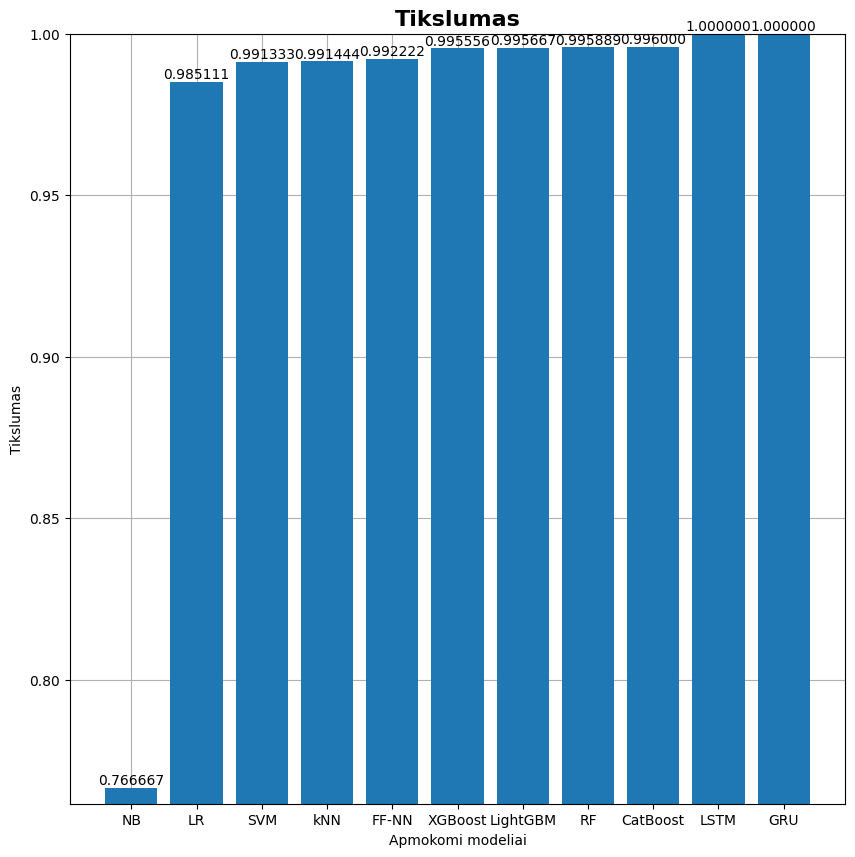

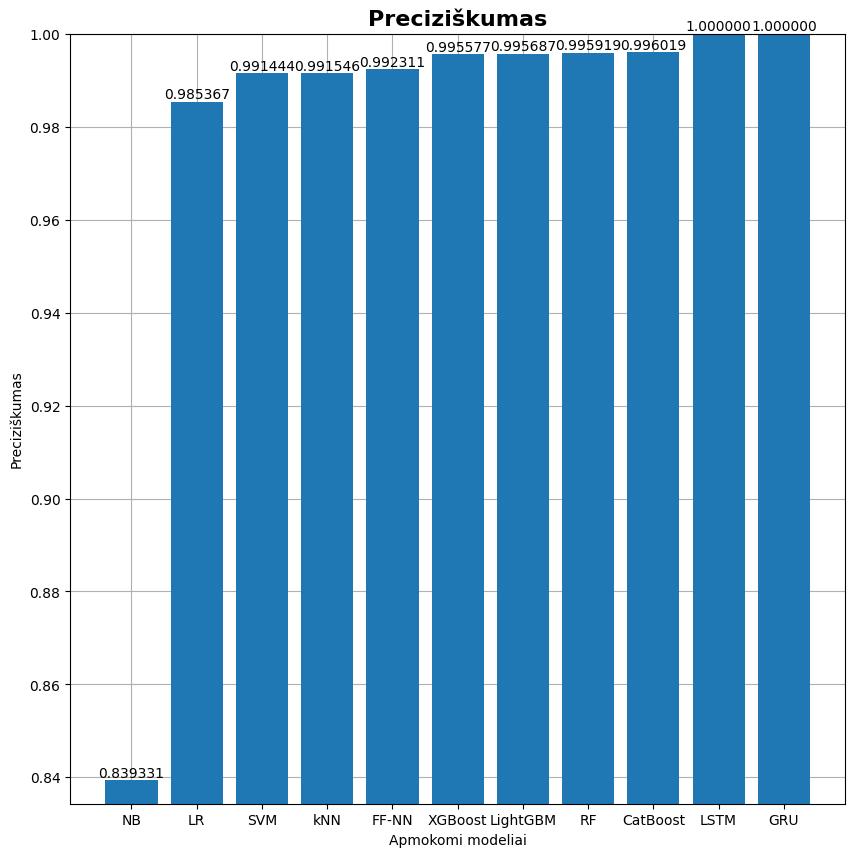

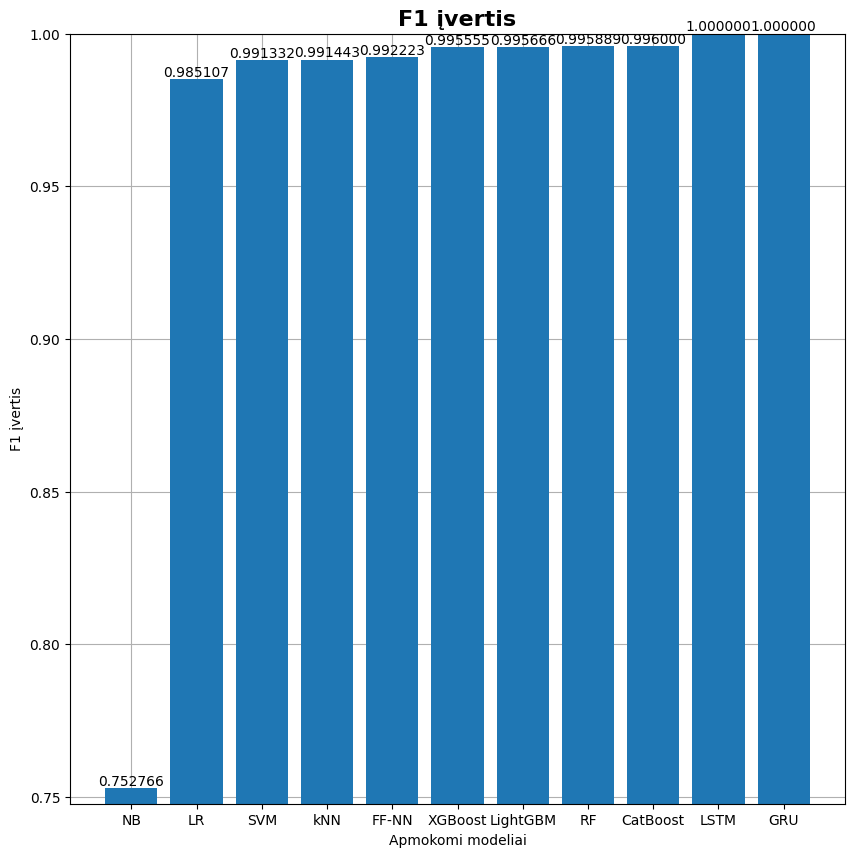

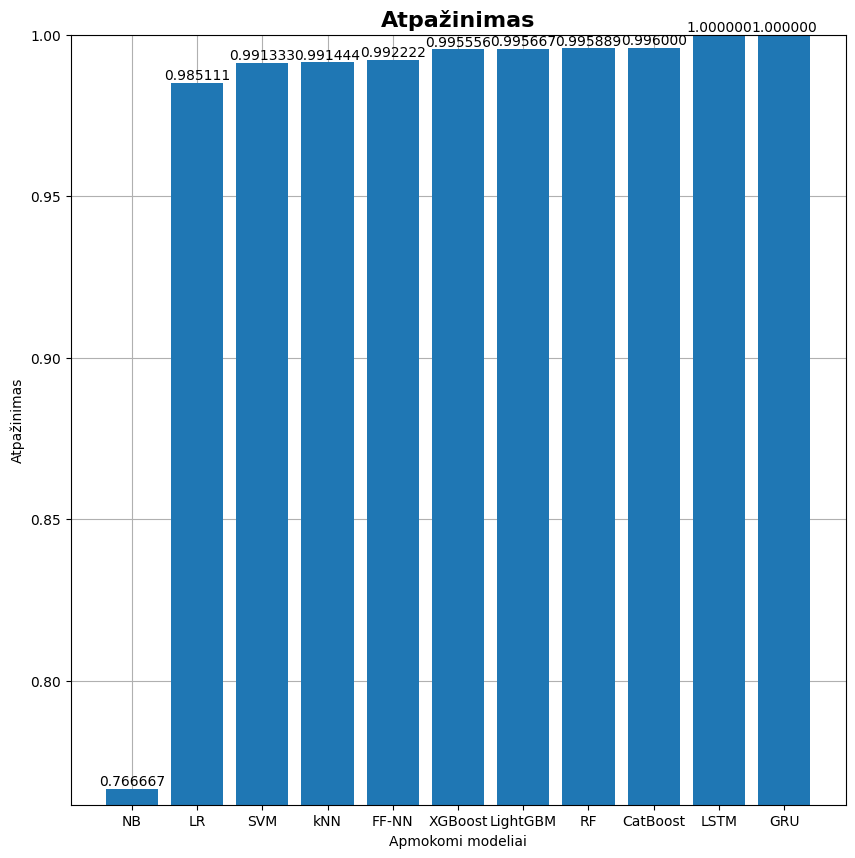

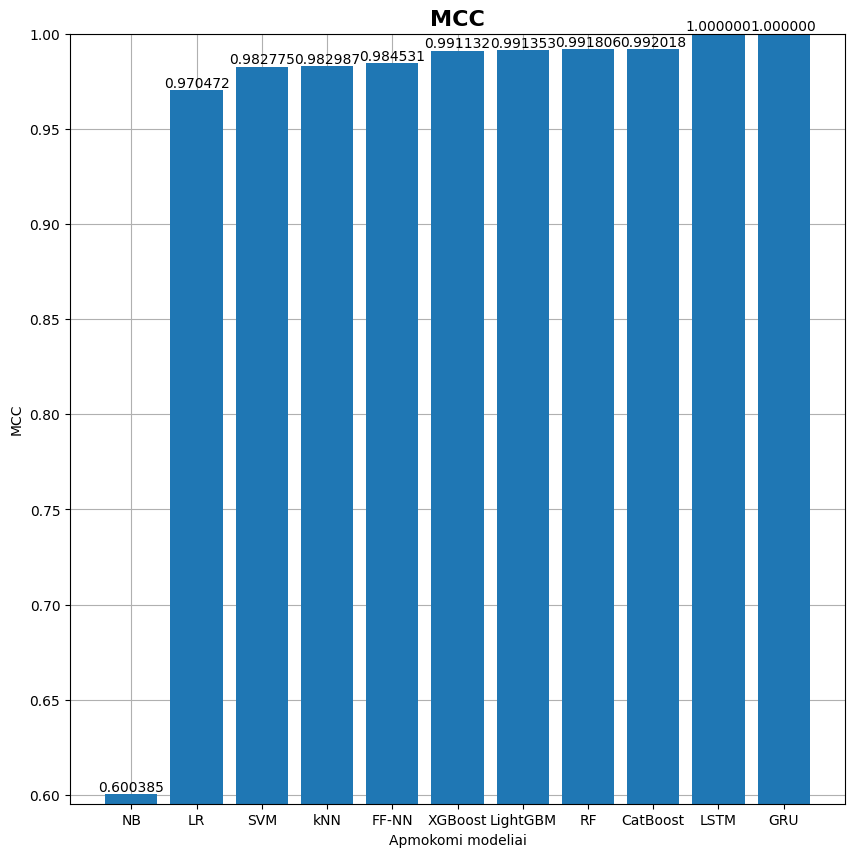

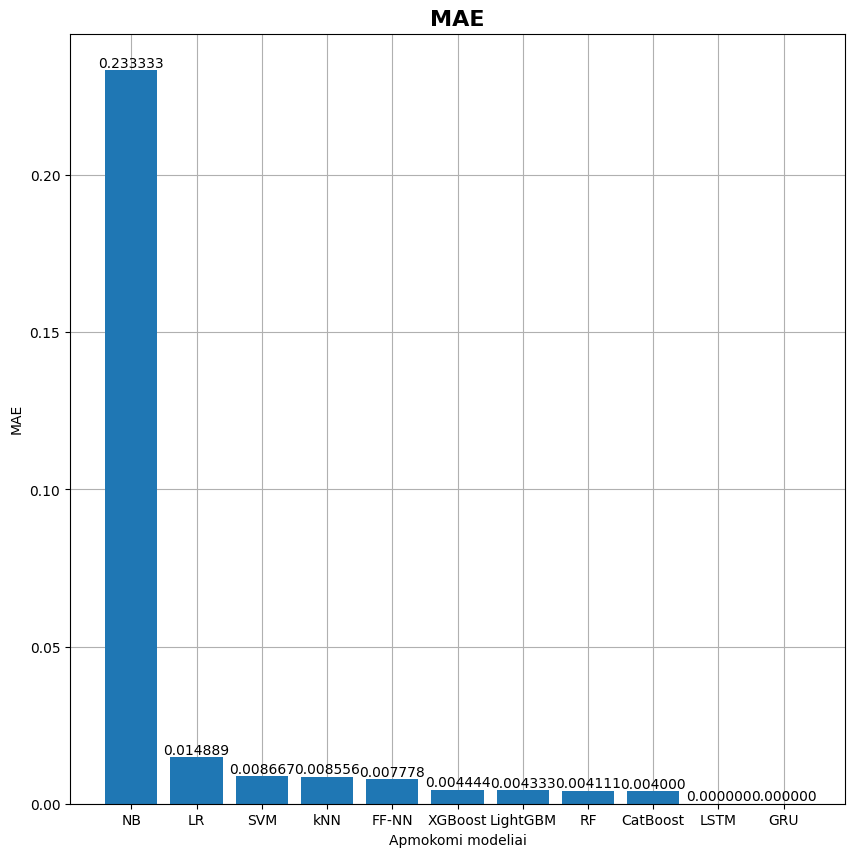

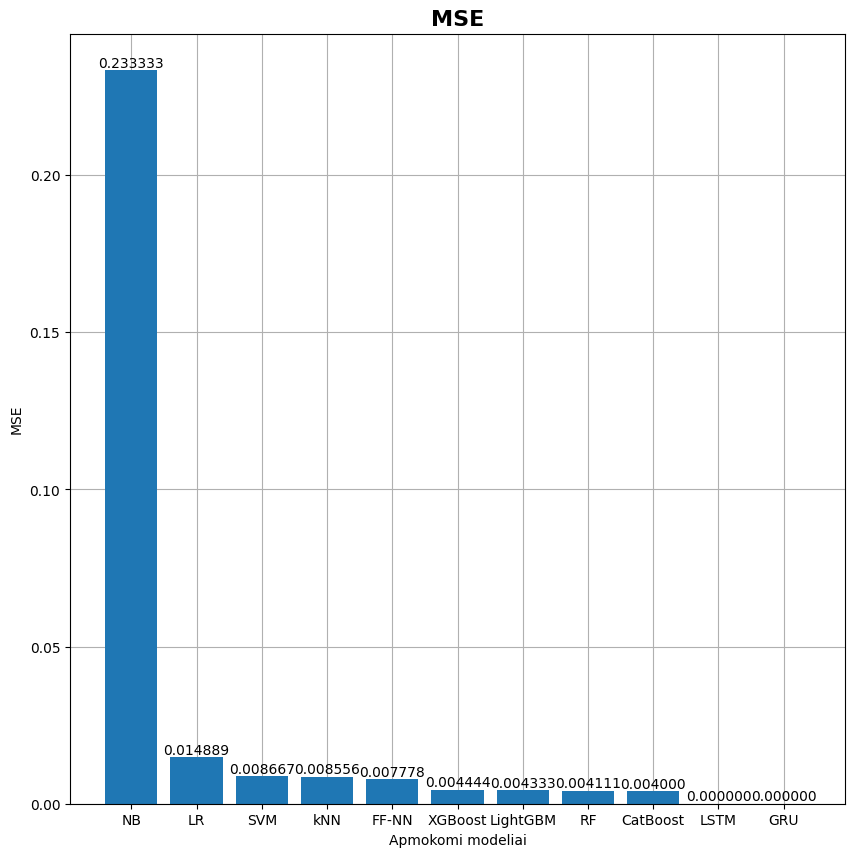

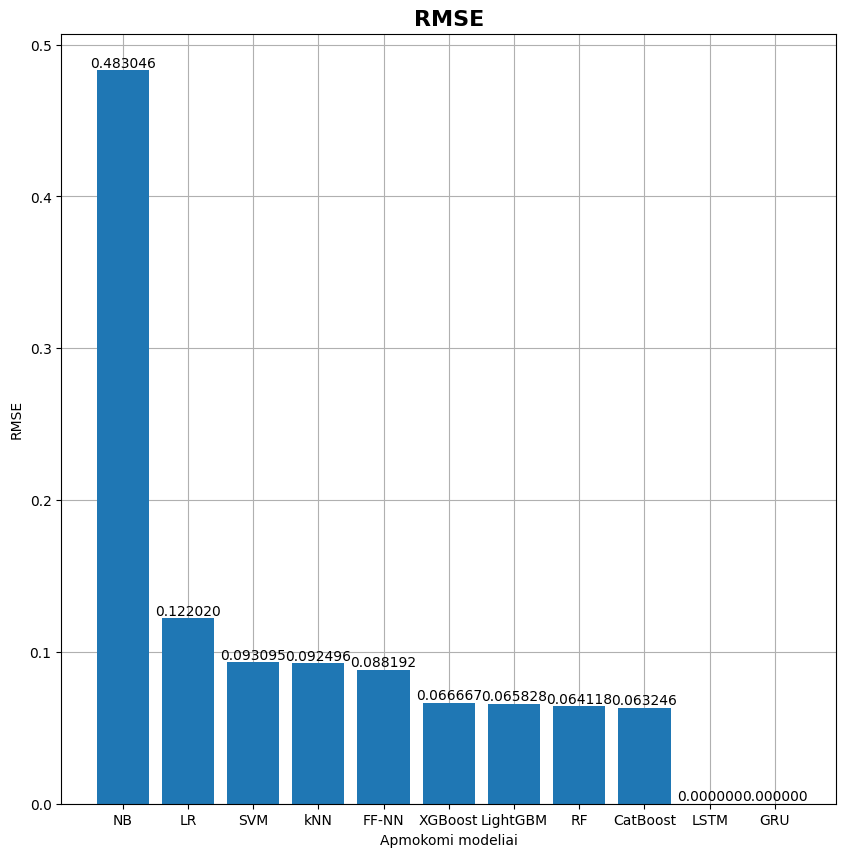

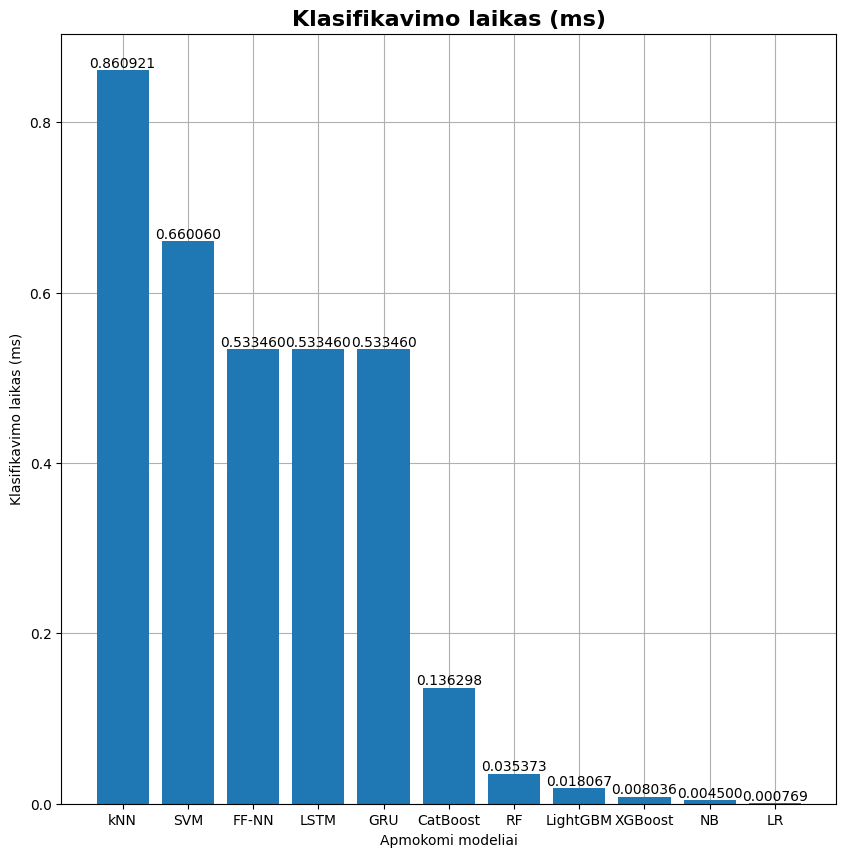

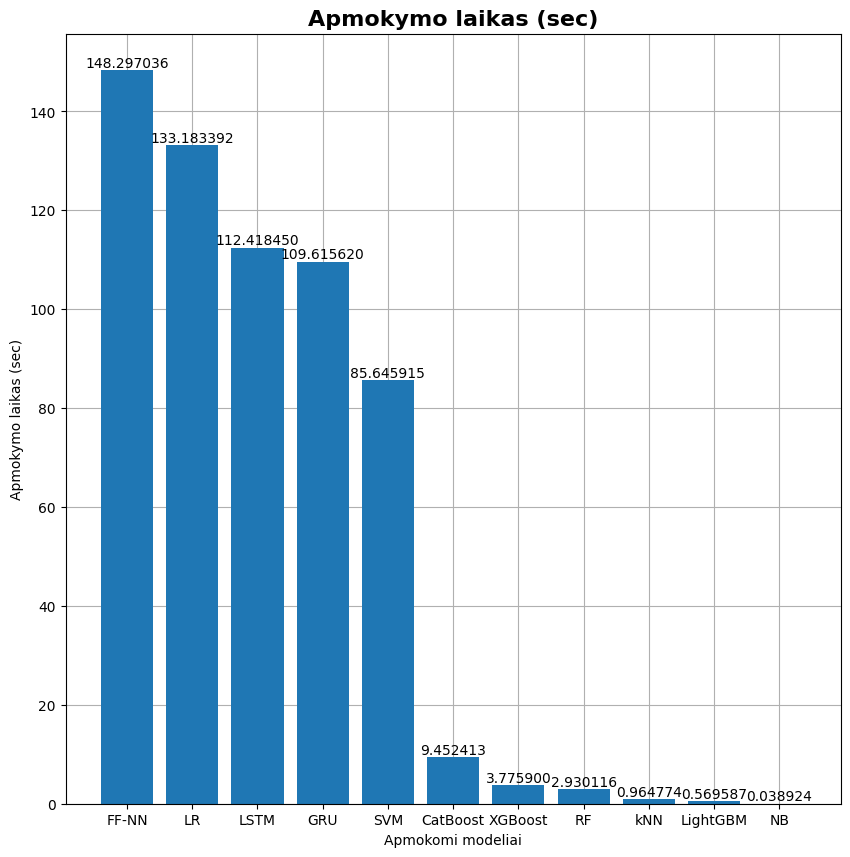

In [93]:
for x in results_df:
    _dict = {}
    name = results_df[x].name
    for keys, values in zip(range(len(results_df[x].keys())), results_df[x]):
        _dict[results_df[x].keys()[keys]] = values
    result_plot(_dict, name)

In [94]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Latency (ms),Time
kNN,0.991444,0.991546,0.991443,0.991444,0.982987,0.008556,0.008556,0.092496,0.860921,0.964774
NB,0.766667,0.839331,0.752766,0.766667,0.600385,0.233333,0.233333,0.483046,0.004500,0.038924
LR,0.985111,0.985367,0.985107,0.985111,0.970472,0.014889,0.014889,0.122020,0.000769,133.183392
RF,0.995889,0.995919,0.995889,0.995889,0.991806,0.004111,0.004111,0.064118,0.035373,2.930116
XGBoost,0.995556,0.995577,0.995555,0.995556,0.991132,0.004444,0.004444,0.066667,0.008036,3.775900
LightGBM,0.995667,0.995687,0.995666,0.995667,0.991353,0.004333,0.004333,0.065828,0.018067,0.569587
CatBoost,0.996000,0.996019,0.996000,0.996000,0.992018,0.004000,0.004000,0.063246,0.136298,9.452413
SVM,0.991333,0.991444,0.991332,0.991333,0.982775,0.008667,0.008667,0.093095,0.660060,85.645915
FF-NN,0.992222,0.992311,0.992223,0.992222,0.984531,0.007778,0.007778,0.088192,0.533460,148.297036
LSTM,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.533460,112.418450


In [95]:
results_dict

{'kNN': [0.9914444444444445,
  0.9915458315293255,
  0.9914433937086831,
  0.9914444444444445,
  np.float64(0.9829874355076118),
  0.008555555555555556,
  0.008555555555555556,
  0.09249624617007739,
  0.8609211444854736,
  0.9647740679997696],
 'NB': [0.7666666666666667,
  0.8393309398059097,
  0.7527658357956241,
  0.7666666666666667,
  np.float64(0.6003854617618655),
  0.23333333333333334,
  0.23333333333333334,
  0.48304589153964794,
  0.004499673843383789,
  0.03892370599987771],
 'LR': [0.9851111111111112,
  0.985367132746673,
  0.9851074390530854,
  0.9851111111111112,
  np.float64(0.9704720205658047),
  0.014888888888888889,
  0.014888888888888889,
  0.12202003478482085,
  0.0007691383361816406,
  133.18339248700022],
 'RF': [0.9958888888888889,
  0.9959185836100017,
  0.9958886703501283,
  0.9958888888888889,
  np.float64(0.9918063759928488),
  0.004111111111111111,
  0.004111111111111111,
  0.06411794687223782,
  0.03537344932556152,
  2.930116074000125],
 'XGBoost': [0.99555